# Using Linear Regression with a polynomial kernel of degree 3

In [25]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from helper import *
from normalEq import *
import time

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Extract the data

In [2]:
data_sample = pd.read_csv('sample.csv')
data_test = pd.read_csv('test.csv')
data_train = pd.read_csv('train.csv')

X_data = data_train.values
y_sample = data_sample.values
X_submission = data_test.values[:,1:]

indices = np.arange(X_data.shape[0])
np.random.shuffle(indices)

test_ratio = 0.1
number_of_test = int(X_data.shape[0] * test_ratio) #assuming we want to test out data with 0.1 percent of all the data
X_test = X_data[indices[:number_of_test], :]
X_train = X_data[indices[number_of_test:], :]

Making sure it was extracted correctly (use your eyes)

In [3]:
print_cases = 5
if True:
    print
    print("**************** PRINTING SOME RAW AND PREPROCESSED INPUT ****************")
    print("Number of samples")
    print(X_data.shape[0])
    print
    print("And has types")
    print(type(X_submission[0,0]))
    print
    print("Pandas Training")
    print(data_train.head(print_cases))
    print("Test")
    print(X_test[:print_cases,:])
    print("Training")
    print(X_train[:print_cases,:])
    print
    print
    print("Pandas Sample Submission")
    print(data_sample.head(print_cases))
    print("Submission Sample")
    print(y_sample[:print_cases])
    print
    print
    print("Pandas Test")
    print(data_test.head(print_cases))
    print("Submission Data")
    print(X_submission[:print_cases,:])
    print

if True:
    print
    print("**************** INPUT SHAPE ****************")
    print("X_train")
    print(X_data.shape)
    print("y_sample")
    print(y_sample.shape)
    print("X_finaltest")
    print(X_submission.shape)
    print
    print
    print


**************** PRINTING SOME RAW AND PREPROCESSED INPUT ****************
Number of samples
900

And has types
<type 'numpy.float64'>

Pandas Training
   Id           y        x1        x2        x3        x4        x5        x6  \
0   0  116.376061  1.276266 -0.854628  1.623901  2.145311  2.037190  2.886639   
1   1  -11.147227 -0.775282  2.314877  0.526552 -0.092230  0.749973  0.017706   
2   2  -86.243884  1.977542  0.861415  1.103856  1.300591  1.968205  1.869624   
3   3   61.683176  1.099147  1.637926  1.703111  0.083907  0.213986  2.119182   
4   4  -27.909104  0.769627  1.120195  0.211530 -1.960123  0.204419  1.284582   

         x7        x8        x9       x10       x11       x12       x13  \
0  0.888302  0.637899  1.148675  0.562217  3.171257  2.152310 -0.818812   
1  2.031269  1.491334  0.553353  0.193640  1.131268 -0.212560  1.159991   
2  1.567783  1.465282 -0.165373 -1.035995 -0.155413  4.345157  1.126727   
3  0.016604  1.244520  0.418590  1.429564  1.798402  0.38993

## 2. Check if functions are correct
We check if each individual function we call is correct. A simple, realistic test case should be sufficient to check the logic
Functions we call are:
- poly3d_kernel
- reg_normal_eq
- rms
- get_train_cross_dataset
- ncr

In [9]:
#Check if rms works
from helper import *

#Just copy pasted from stackoverflow.. JUST IN CASE..

In [10]:
#Check if reg_normal_eq works
from helper import *
from normalEq import *

In [11]:
#Check if poly3d_kernel works
from helper import *

In [12]:
from helper import *


## 3. Cross validate for best lambda

First, set all parameters that are used for testing

In [13]:
k = 5 #folds of cross-validation
#lam_range = np.logspace(-5, 5, num=317)#[1e-8, 1e-3, 1e2] #we choose a prime number
#lam_range = np.logspace(-16, -12, num=101)
#lam_range = np.logspace(0.2, 4.5, num=101)
lam_range = np.logspace(-16, 8, num=101) #1999


X = np.split(X_train[:,2:], k, axis=0)
y = np.split(X_train[:,1], k, axis=0)

Second, check if any corner-cases apply for the selected parameters

In [14]:
print(X[0].shape)
print(y[0].shape)

if X_data.shape[0] % k != 0:
    print("Number of samples not divisible by k!")
    sys.exit(0)

(162, 15)
(162,)


Third, run the tests

In [15]:
from helper import *
from normalEq import *

loss_dict = []
lam_dict = []
total_error = 0.0

for lam in lam_range:
    total_error = 0
    old_loss = 1000000
    
    for i in range(k):
        X_train, y_train, X_cv, y_cv = get_train_cross_dataset(X, y, i)
        
        #pass X_train and X_cv through the kernel function first!
        X_train = poly3d_kernel(X_train)
        X_cv = poly3d_kernel(X_cv)
        
        #apply to training function, then measure the error
        weights = reg_normal_eq(X_train, y_train, lam)
        predictions = np.dot(X_cv, weights)
        loss = rms(predictions, y_cv)    
        
        if loss < old_loss:
            best_weights = weights
            old_loss = loss
    
        total_error += loss /  X_cv.shape[0] #recording the loss per training example! 
       
    lam_dict.append(lam)
    loss_dict.append(total_error)    
    
print best_weights  

[  2.34171789e-05  -3.36696482e-05  -3.18123713e-06   1.37171339e-04
  -2.84838020e-05  -7.23749325e-05   4.87797391e-05  -6.36871799e-05
  -1.10190856e-04   7.11226353e-05   2.04522225e-04   6.17628267e-05
  -1.07525958e-05   6.66086554e-05  -4.62810966e-05   9.31419509e-05
   0.00000000e+00  -9.20564233e-05   6.62940558e-05  -6.97854330e-05
  -1.57227932e-04  -4.70367470e-05  -1.23252887e-04  -1.75720595e-04
   2.21399221e-05   1.79663232e-04  -6.89333632e-06  -7.19359738e-05
  -7.17900044e-06  -9.17194246e-05   2.73002436e-05   7.65510653e-05
   2.16024762e-04   5.65011948e-05   8.21095853e-06   1.74595811e-04
   2.47385591e-05  -4.57959566e-05   1.64112973e-04   2.95608877e-04
   1.36196244e-04   6.82589289e-05   1.43876968e-04   3.73416456e-05
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00

Fourth, create the graph to decide which value of lambda is the best

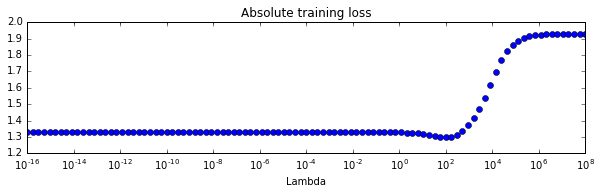

('Minimal loss', 1.2999498503322364)
('Minimizing lam: ', 100.0)
Loss: 1.29994985033, lam: 100.0
Loss: 1.30224927026, lam: 57.5439937337
Loss: 1.30320387316, lam: 173.780082875
Loss: 1.30712471974, lam: 33.1131121483
Loss: 1.31271664502, lam: 19.0546071796
Loss: 1.31554876691, lam: 301.99517204
Loss: 1.31794302004, lam: 10.9647819614
Loss: 1.32224761948, lam: 6.3095734448
Loss: 1.32547108117, lam: 3.6307805477
Loss: 1.32771366876, lam: 2.08929613085
Loss: 1.32918919598, lam: 1.20226443462
Loss: 1.33012004398, lam: 0.691830970919
Loss: 1.33068919073, lam: 0.398107170553
Loss: 1.33102953113, lam: 0.229086765277
Loss: 1.33123004178, lam: 0.131825673856
Loss: 1.33134705998, lam: 0.0758577575029
Loss: 1.3314149578, lam: 0.043651583224
Loss: 1.33145421845, lam: 0.0251188643151
Loss: 1.33147687411, lam: 0.0144543977075
Loss: 1.33148993226, lam: 0.00831763771103
Loss: 1.33149745347, lam: 0.00478630092323
Loss: 1.33150178382, lam: 0.00275422870334
Loss: 1.33150427645, lam: 0.00158489319246
Loss

In [17]:
plt.subplot(3, 1, 1)
plt.title('Absolute training loss')
plt.xlabel('Lambda')
plt.semilogx(lam_dict, loss_dict, 'o')
plt.show()

print("Minimal loss", min(loss_dict))
index = np.argmin(loss_dict)
indecies = np.argsort(loss_dict)[::-1][-50:][::-1]
print("Minimizing lam: ", lam_dict[index])
for i in range(50):
    print("Loss: " + str(loss_dict[indecies[i]]) + ", lam: " + str(lam_dict[indecies[i]]))
    
best_lambda = lam_dict[index]
print best_lambda

## 4. Test accuracy of the model

First, recreate the weights with the best found lambda using the entire training set

In [32]:
from helper import *
from normalEq import *

#pass through kernel
X_final = poly3d_kernel(X_data[:,2:])
y_final = X_data[:,1]

#predict
weights = reg_normal_eq(X_final, y_final, best_lambda)
y_pred_test = np.dot(X_final, weights)

loss = rms(y_pred_test, y_final)

print(sub_data.shape)
print(sub_data)
print(loss)

(2000, 2)
[[  900.            59.89449123]
 [  901.            32.33463045]
 [  902.            -9.52221446]
 ..., 
 [ 2897.            16.79529751]
 [ 2898.            29.1814905 ]
 [ 2899.            40.07120057]]
36.4422676653


## 5. Predict for unseen dataset and export predicted data

In [ ]:
X_sub = poly3d_kernel(X_submission)
print X_sub.shape
print weights.shape
y_pred_test = np.dot(X_sub, weights)

sub_data = np.column_stack((data_test.values[:,0], y_pred_test))

In [ ]:
submission = pd.DataFrame(sub_data, columns = ["Id", "y"])
submission.Id = submission.Id.astype(int)
print(submission)

time.strftime("%Y%m%d-%H%M%S")